In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
import matplotlib.colors as mcolors

c1 = 'tab:blue'
c2 = 'tab:orange'
c3 = 'tab:green'
c4 = 'tab:red'
c5 = 'tab:purple'
c6 = 'tab:brown'
c7 = 'tab:pink'
c8 = 'tab:gray'
c9 = 'tab:olive'
c10= 'tab:cyan'

# Parameters set

In [3]:
# parameters

t_max = 180             # simulation duration
dt    = 0.001
pop   = 1000000         # total population
b     = 1
m     = 0.04
g     = 0.2 - m         # E -> I 1/incubtation
dh    = 0.007
rh    = 0.093
do    = 0.010
ro    = 0.090

# initial state

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [4]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [5]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [6]:
def tSEIRD_matrix(Se,Sp,n,p,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [7]:
def tSEIRD_max(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Positive']),np.max(df_['TP']),np.max(df_['FP']),
            np.max(df_['Hospitalised']),np.max(df_['Sh']),np.max(df_['Eh']),np.max(df_['Ih']),
            np.max(df_['Dead']),np.max(df_['Dh']),np.max(df_['Do'])
           ]

# Heatmaps at prefixed testing characteristics

In [23]:
# generate data

v = []

for i in np.linspace(0,4,101):
    for j in np.linspace(0,0.8,101):
        v.append(tSEIRD_max(0.7,0.7,i,j))

np.savetxt('v.csv',v,delimiter=',')

<ipython-input-5-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


In [8]:
# open and tidy data

v = pd.read_csv('v.csv',header=None)

pos_test_fix   = np.array(v)[:, 0].reshape((101,101))
hosp_test_fix  = np.array(v)[:, 3].reshape((101,101))
death_test_fix = np.array(v)[:, 7].reshape((101,101))

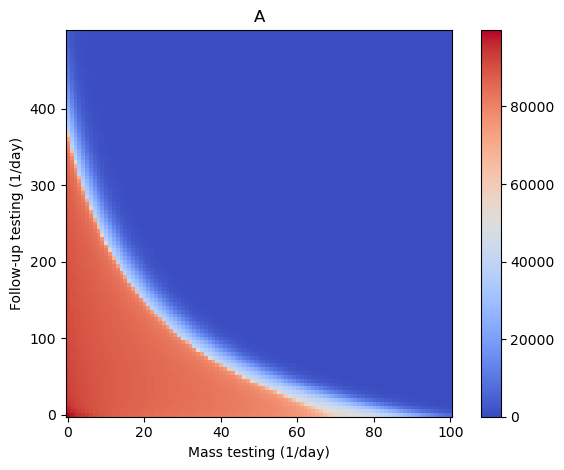

In [9]:
# upper panel of Fig. 4A

plt.figure()
plt.title('A')
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')
plt.imshow(death_test_fix,interpolation='nearest',vmin=0,vmax=np.max(death_test_fix),cmap='coolwarm')
plt.colorbar(ticks=[0, 20000, 40000, 60000, 80000])
plt.gca().invert_yaxis()

plt.yticks([0, 20, 40, 60, 80], [0, 100, 200, 300, 400])

plt.tight_layout()
plt.show()

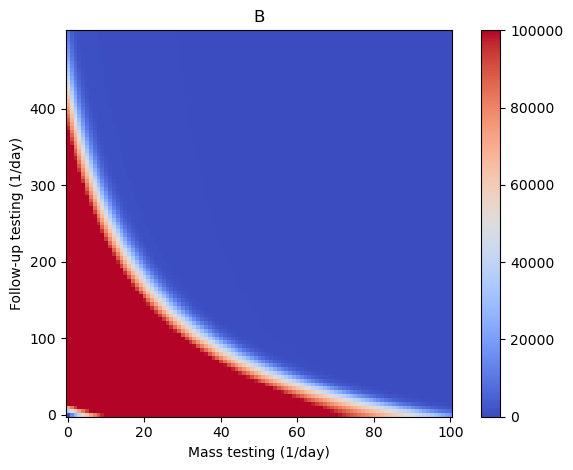

In [10]:
# upper panel of Fig. 4B

plt.figure()
plt.title('B')
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')
plt.imshow(hosp_test_fix,interpolation='nearest',vmin=0,vmax=np.max(hosp_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.yticks([0, 20, 40, 60, 80], [0, 100, 200, 300, 400])

plt.tight_layout()
plt.show()

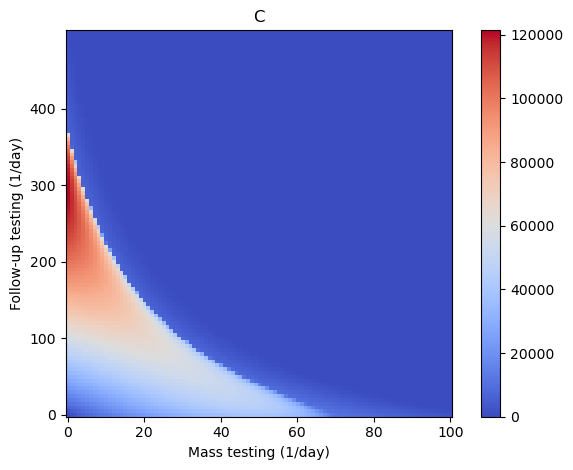

In [11]:
# upper panel of Fig. 4C

plt.figure()
plt.title('C')
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')
plt.imshow(pos_test_fix,interpolation='nearest',vmin=0,vmax=np.max(pos_test_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.yticks([0,20, 40, 60, 80], [0,100, 200, 300, 400])

plt.tight_layout()
plt.show()

# Total resource dependencies of variables

In [14]:
s1 = []

# line from follow-up testing of 1 to mass testing 0f 1

for i in np.linspace(0,1,101):
    s1.append(tSEIRD_max(0.7,0.7,(1-i),i))
    
np.savetxt('s1.csv',s1,delimiter=',')

<ipython-input-4-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)
NumExpr defaulting to 8 threads.


In [12]:
s1 = pd.read_csv('s1.csv',header=None)

df1 = pd.DataFrame({
    'follow_up': 1-(np.linspace(0,1,101)),
    'take_up': np.linspace(0,1,101),
    'pos1': np.array(s1)[:,0],
    'hos1': np.array(s1)[:,3],
    'des1': np.array(s1)[:,7],
})

In [13]:
s2 = []

# line from follow-up testing of 3 to mass testing of 0.6

for i in np.linspace(0,0.6,101):
    s2.append(tSEIRD_max(0.7,0.7,(3-5*i),i))
    
np.savetxt('s2.csv',s2,delimiter=',')

KeyboardInterrupt: 

In [14]:
s2 = pd.read_csv('s2.csv',header=None)

df2 = pd.DataFrame({
    'follow_up': 3-5*(np.linspace(0,0.6,101)),
    'take_up': np.linspace(0,0.6,101),
    'pos2': np.array(s2)[:,0],
    'hos2': np.array(s2)[:,3],
    'des2': np.array(s2)[:,7],
})

In [ ]:
s3 = []

# line from follow-up testing of 5 to mass testing of 0.5

for i in np.linspace(0,0.5,101):
    s3.append(tSEIRD_max(0.7,0.7,(5-10*i),i))
    
np.savetxt('s3.csv',s3,delimiter=',')

In [15]:
s3 = pd.read_csv('s3.csv',header=None)

df3 = pd.DataFrame({
    'follow_up': 5-10*(np.linspace(0,0.5,101)),
    'take_up': np.linspace(0,0.5,101),
    'pos3': np.array(s3)[:,0],
    'hos3': np.array(s3)[:,3],
    'des3': np.array(s3)[:,7],
})

# Total resource on the three variables

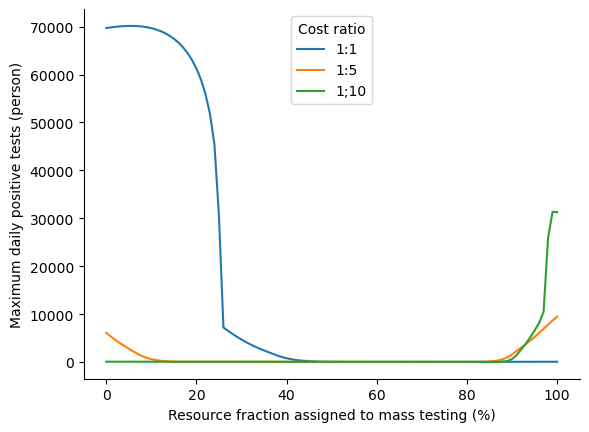

In [38]:
# lower panel of Fig. 4A

x = np.linspace(0,100,101)
y1 = df1['pos1']
y2 = df2['pos2']
y3 = df3['pos3']

plt.title('')
plt.xlabel('Resource fraction assigned to mass testing (%)')
plt.ylabel('Maximum daily positive tests (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(['1:1', '1:5', '1;10'],
            loc='upper center', title='Cost ratio')

plt.show()

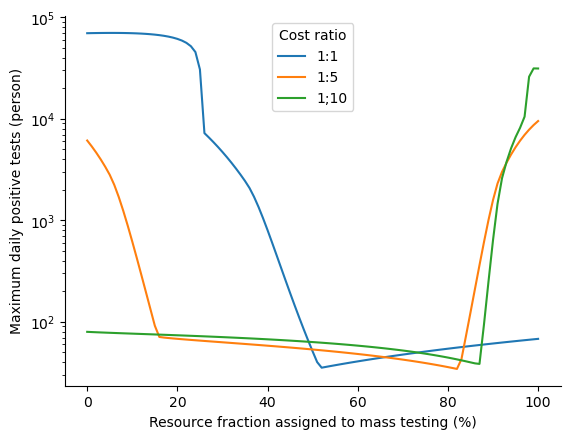

In [37]:
# lower panel of Fig. 4A

x = np.linspace(0,100,101)
y1 = df1['pos1']
y2 = df2['pos2']
y3 = df3['pos3']

plt.title('')
plt.xlabel('Resource fraction assigned to mass testing (%)')
plt.ylabel('Maximum daily positive tests (person)')

plt.semilogy()
plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(['1:1', '1:5', '1;10'],
            loc='upper center', title='Cost ratio')

plt.show()

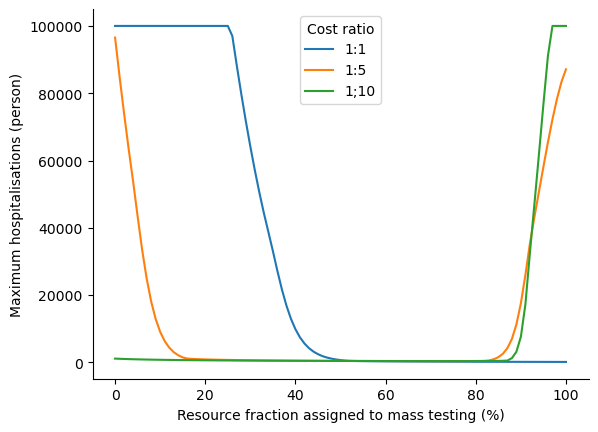

In [35]:
# lower panel of Fig. 4B

x = np.linspace(0,100,101)
y1 = df1['hos1']
y2 = df2['hos2']
y3 = df3['hos3']

plt.title('')
plt.xlabel('Resource fraction assigned to mass testing (%)')
plt.ylabel('Maximum hospitalisations (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(['1:1', '1:5', '1;10'],
            loc='upper center', title='Cost ratio')

plt.show()

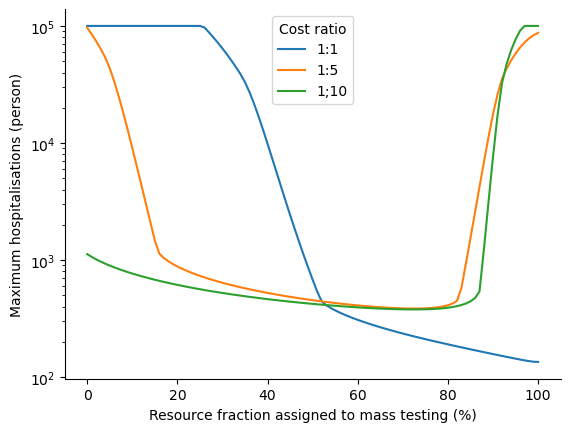

In [34]:
# lower panel of Fig. 4B

x = np.linspace(0,100,101)
y1 = df1['hos1']
y2 = df2['hos2']
y3 = df3['hos3']

plt.title('')
plt.xlabel('Resource fraction assigned to mass testing (%)')
plt.ylabel('Maximum hospitalisations (person)')

plt.semilogy()
plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(['1:1', '1:5', '1;10'],
            loc='upper center', title='Cost ratio')

plt.show()

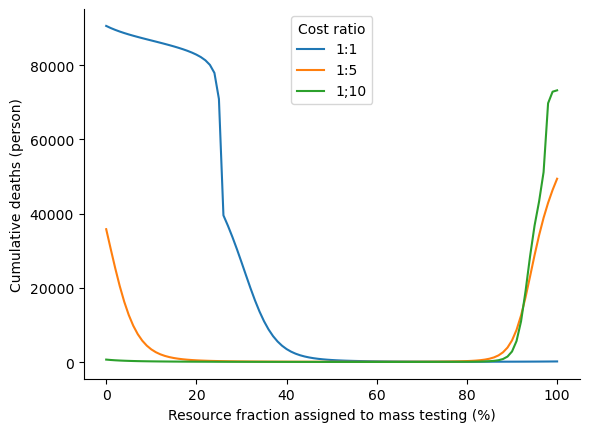

In [33]:
# lower panel of Fig. 4C

x = np.linspace(0,100,101)
y1 = df1['des1']
y2 = df2['des2']
y3 = df3['des3']

# プロット
plt.title('')
plt.xlabel('Resource fraction assigned to mass testing (%)')
plt.ylabel('Cumulative deaths (person)')

plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(['1:1', '1:5', '1;10'],
            loc='upper center', title='Cost ratio')

plt.show()

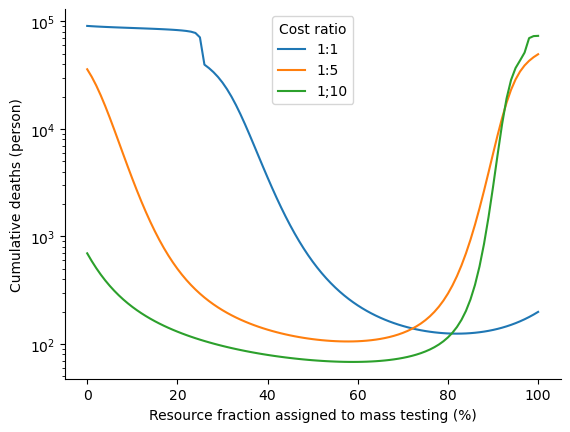

In [32]:
# lower panel of Fig. 4C

x = np.linspace(0,100,101)
y1 = df1['des1']
y2 = df2['des2']
y3 = df3['des3']

# プロット
plt.title('')
plt.xlabel('Resource fraction assigned to mass testing (%)')
plt.ylabel('Cumulative deaths (person)')

plt.semilogy()
plt.plot(x, y1, label='1', color =c1)
plt.plot(x, y2, label='2', color =c2)
plt.plot(x, y3, label='3', color =c3)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(['1:1', '1:5', '1;10'],
            loc='upper center', title='Cost ratio')

plt.show()

# Maximum and minimum death number search

In [22]:
print('検査コスト比1:1の時')
print(np.unravel_index(np.argmax(y1), y1.shape))
_max11 = np.unravel_index(np.argmax(y1), y1.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min11 = np.unravel_index(np.argmin(y1), y1.shape)[0]

print('検査コスト比1:5の時')
print(np.unravel_index(np.argmax(y2), y2.shape))
_max15 = np.unravel_index(np.argmax(y2), y2.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min15 = np.unravel_index(np.argmin(y2), y2.shape)[0]

print('検査コスト比1:10の時')
print(np.unravel_index(np.argmax(y3), y3.shape))
_max110 = np.unravel_index(np.argmax(y3), y3.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min110 = np.unravel_index(np.argmin(y3), y3.shape)[0]

検査コスト比1:1の時
(0,)
(82,)
検査コスト比1:5の時
(100,)
(82,)
検査コスト比1:10の時
(100,)
(82,)


# And values at points

In [23]:
print(np.round(y1[_max11]))
print(np.round(y1[_min11]))

print(np.round(y2[_max15]))
print(np.round(y2[_min15]))

print(np.round(y3[_max110]))
print(np.round(y3[_min110]))

90596.0
125.0
49424.0
106.0
73241.0
68.0


In [39]:
# 入院者数に対して同様に

y1 = df1['hos1']
y2 = df2['hos2']
y3 = df3['hos3']

print('検査コスト比1:1の時')
print(np.unravel_index(np.argmax(y1), y1.shape))
_max11 = np.unravel_index(np.argmax(y1), y1.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min11 = np.unravel_index(np.argmin(y1), y1.shape)[0]

print('検査コスト比1:5の時')
print(np.unravel_index(np.argmax(y2), y2.shape))
_max15 = np.unravel_index(np.argmax(y2), y2.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min15 = np.unravel_index(np.argmin(y2), y2.shape)[0]

print('検査コスト比1:10の時')
print(np.unravel_index(np.argmax(y3), y3.shape))
_max110 = np.unravel_index(np.argmax(y3), y3.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min110 = np.unravel_index(np.argmin(y3), y3.shape)[0]

print(np.round(y1[_max11]))
print(np.round(y1[_min11]))

print(np.round(y2[_max15]))
print(np.round(y2[_min15]))

print(np.round(y3[_max110]))
print(np.round(y3[_min110]))

検査コスト比1:1の時
(0,)
(100,)
検査コスト比1:5の時
(0,)
(100,)
検査コスト比1:10の時
(99,)
(100,)
100002.0
135.0
96525.0
386.0
100001.0
379.0


In [40]:
# 検査陽性者数に対して同様に

y1 = df1['pos1']
y2 = df2['pos2']
y3 = df3['pos3']

print('検査コスト比1:1の時')
print(np.unravel_index(np.argmax(y1), y1.shape))
_max11 = np.unravel_index(np.argmax(y1), y1.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min11 = np.unravel_index(np.argmin(y1), y1.shape)[0]

print('検査コスト比1:5の時')
print(np.unravel_index(np.argmax(y2), y2.shape))
_max15 = np.unravel_index(np.argmax(y2), y2.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min15 = np.unravel_index(np.argmin(y2), y2.shape)[0]

print('検査コスト比1:10の時')
print(np.unravel_index(np.argmax(y3), y3.shape))
_max110 = np.unravel_index(np.argmax(y3), y3.shape)[0]
print(np.unravel_index(np.argmin(y1), y1.shape))
_min110 = np.unravel_index(np.argmin(y3), y3.shape)[0]

print(np.round(y1[_max11]))
print(np.round(y1[_min11]))

print(np.round(y2[_max15]))
print(np.round(y2[_min15]))

print(np.round(y3[_max110]))
print(np.round(y3[_min110]))

検査コスト比1:1の時
(5,)
(52,)
検査コスト比1:5の時
(100,)
(52,)
検査コスト比1:10の時
(99,)
(52,)
70146.0
35.0
9502.0
34.0
31355.0
38.0


https://sabopy.com/py/matplotlib-5/

([<matplotlib.axis.YTick at 0x2aa584830d0>,
 [Text(0, 0, '0'),
  Text(0, 20, '100'),
  Text(0, 40, '200'),
  Text(0, 60, '300'),
  Text(0, 80, '400')])

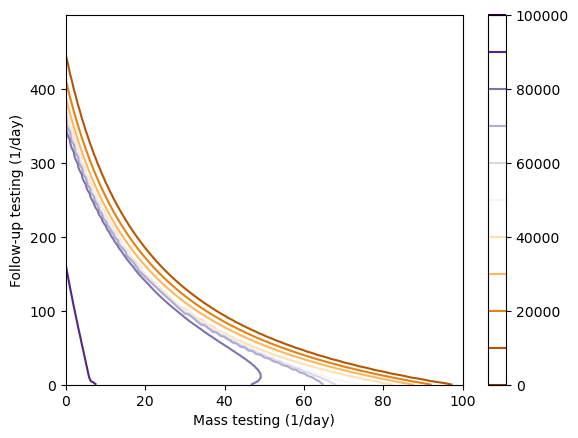

In [75]:
# upper panel of Fig. 4A

fig, ax = plt.subplots()

# plt.figure()
# plt.title('4A'"''")
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')

x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
X, Y = np.meshgrid(x, y)
Z = death_test_fix

# contf = ax.contourf(X, Y, Z, 10, cmap='PuOr')
# ax.set_aspect('equal','box')

cont10 = ax.contour(X, Y, Z, 10, cmap='PuOr')
plt.colorbar(cont10)

#plt.imshow(death_test_fix,interpolation='nearest',vmin=0,vmax=np.max(death_test_fix),cmap='coolwarm')
#plt.colorbar(ticks=[0, 20000, 40000, 60000, 80000])
# plt.gca().invert_yaxis()

plt.yticks([0, 20, 40, 60, 80], [0, 100, 200, 300, 400])

# plt.tight_layout()
# plt.show()

([<matplotlib.axis.YTick at 0x2aa5869b9d0>,
 [Text(0, 0, '0'),
  Text(0, 20, '100'),
  Text(0, 40, '200'),
  Text(0, 60, '300'),
  Text(0, 80, '400')])

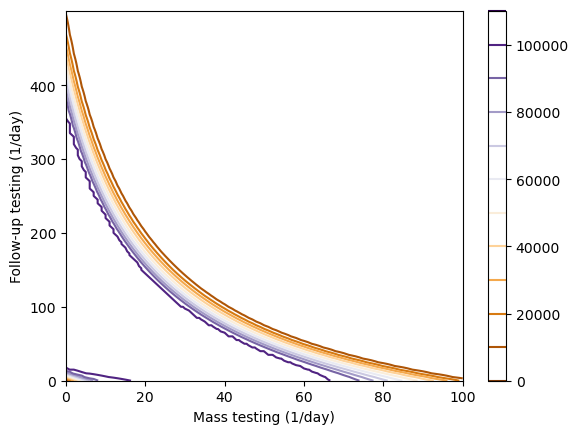

In [76]:
# upper panel of Fig. 4A

fig, ax = plt.subplots()

# plt.figure()
# plt.title('4B'"''")
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')

x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
X, Y = np.meshgrid(x, y)
Z = hosp_test_fix

# contf = ax.contourf(X, Y, Z, 10, cmap='PuOr')
# ax.set_aspect('equal','box')

cont10 = ax.contour(X, Y, Z, 10, cmap='PuOr')
plt.colorbar(cont10)

#plt.imshow(death_test_fix,interpolation='nearest',vmin=0,vmax=np.max(death_test_fix),cmap='coolwarm')
#plt.colorbar(ticks=[0, 20000, 40000, 60000, 80000])
# plt.gca().invert_yaxis()

plt.yticks([0, 20, 40, 60, 80], [0, 100, 200, 300, 400])

# plt.tight_layout()
# plt.show()

([<matplotlib.axis.YTick at 0x2aa5876c910>,
 [Text(0, 0, '0'),
  Text(0, 20, '100'),
  Text(0, 40, '200'),
  Text(0, 60, '300'),
  Text(0, 80, '400')])

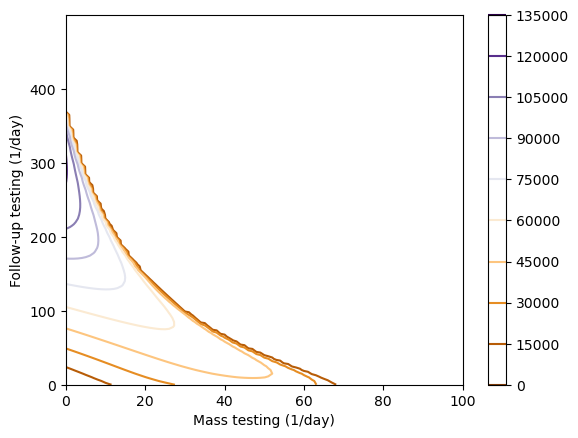

In [77]:
# upper panel of Fig. 4A

fig, ax = plt.subplots()

# plt.figure()
# plt.title('4C'"''")
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')

x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
X, Y = np.meshgrid(x, y)
Z = pos_test_fix

# contf = ax.contourf(X, Y, Z, 10, cmap='PuOr')
# ax.set_aspect('equal','box')

cont10 = ax.contour(X, Y, Z, 10, cmap='PuOr')
plt.colorbar(cont10)

#plt.imshow(death_test_fix,interpolation='nearest',vmin=0,vmax=np.max(death_test_fix),cmap='coolwarm')
#plt.colorbar(ticks=[0, 20000, 40000, 60000, 80000])
# plt.gca().invert_yaxis()

plt.yticks([0, 20, 40, 60, 80], [0, 100, 200, 300, 400])

# plt.tight_layout()
# plt.show()

([<matplotlib.axis.YTick at 0x2aa56d4de20>,
 [Text(0, 0, '0'),
  Text(0, 20, '100'),
  Text(0, 40, '200'),
  Text(0, 60, '300'),
  Text(0, 80, '400')])

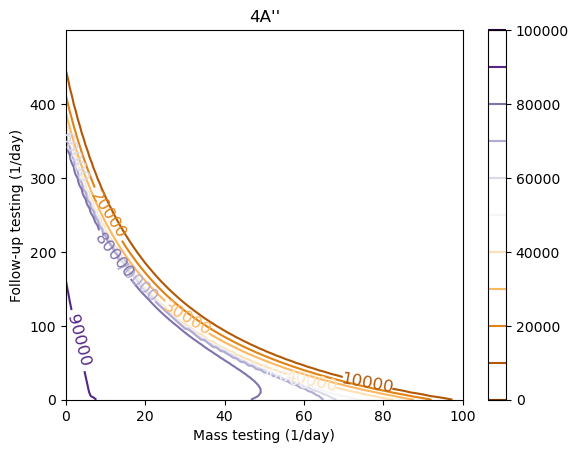

In [72]:
# upper panel of Fig. 4A

fig, ax = plt.subplots()

# plt.figure()
plt.title('4A'"''")
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')

x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
X, Y = np.meshgrid(x, y)
Z = death_test_fix

# contf = ax.contourf(X, Y, Z, 10, cmap='PuOr')
# ax.set_aspect('equal','box')

# cont10 = ax.contour(X, Y, Z, 10, cmap='PuOr')
# plt.colorbar(cont10)

cont_cl = ax.contour(X, Y, Z,10, cmap='PuOr')
ax.clabel(cont_cl, inline=True, fontsize=12)
plt.colorbar(cont_cl)

# plt.imshow(death_test_fix,interpolation='nearest',vmin=0,vmax=np.max(death_test_fix),cmap='coolwarm')
# plt.colorbar(ticks=[0, 20000, 40000, 60000, 80000])
# plt.gca().invert_yaxis()

plt.yticks([0, 20, 40, 60, 80], [0, 100, 200, 300, 400])

# plt.tight_layout()
# plt.show()

([<matplotlib.axis.YTick at 0x2aa570cc850>,
 [Text(0, 0, '0'),
  Text(0, 20, '100'),
  Text(0, 40, '200'),
  Text(0, 60, '300'),
  Text(0, 80, '400')])

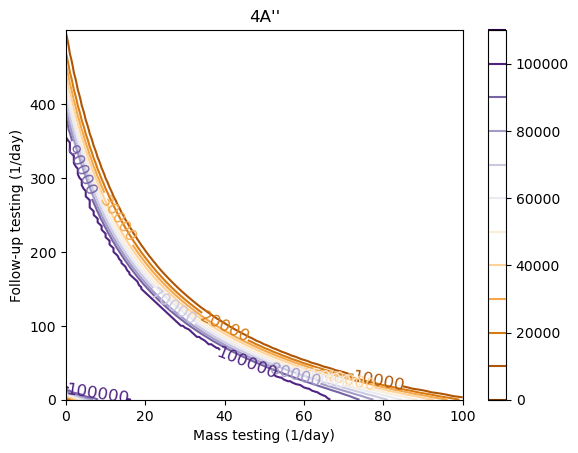

In [73]:
# upper panel of Fig. 4A

fig, ax = plt.subplots()

# plt.figure()
plt.title('4A'"''")
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')

x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
X, Y = np.meshgrid(x, y)
Z = hosp_test_fix

# contf = ax.contourf(X, Y, Z, 10, cmap='PuOr')
# ax.set_aspect('equal','box')

# cont10 = ax.contour(X, Y, Z, 10, cmap='PuOr')
# plt.colorbar(cont10)

cont_cl = ax.contour(X, Y, Z,10, cmap='PuOr')
ax.clabel(cont_cl, inline=True, fontsize=12)
plt.colorbar(cont_cl)

# plt.imshow(death_test_fix,interpolation='nearest',vmin=0,vmax=np.max(death_test_fix),cmap='coolwarm')
# plt.colorbar(ticks=[0, 20000, 40000, 60000, 80000])
# plt.gca().invert_yaxis()

plt.yticks([0, 20, 40, 60, 80], [0, 100, 200, 300, 400])

# plt.tight_layout()
# plt.show()

([<matplotlib.axis.YTick at 0x2aa5851a2e0>,
 [Text(0, 0, '0'),
  Text(0, 20, '100'),
  Text(0, 40, '200'),
  Text(0, 60, '300'),
  Text(0, 80, '400')])

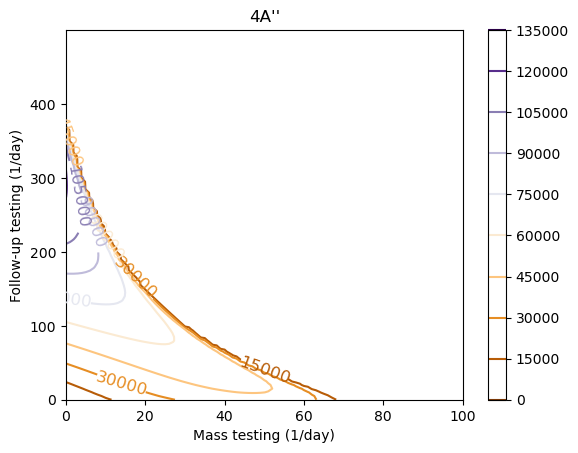

In [74]:
# upper panel of Fig. 4A

fig, ax = plt.subplots()

# plt.figure()
plt.title('4A'"''")
plt.xlabel('Mass testing (1/day)')
plt.ylabel('Follow-up testing (1/day)')

x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
X, Y = np.meshgrid(x, y)
Z = pos_test_fix

# contf = ax.contourf(X, Y, Z, 10, cmap='PuOr')
# ax.set_aspect('equal','box')

# cont10 = ax.contour(X, Y, Z, 10, cmap='PuOr')
# plt.colorbar(cont10)

cont_cl = ax.contour(X, Y, Z,10, cmap='PuOr')
ax.clabel(cont_cl, inline=True, fontsize=12)
plt.colorbar(cont_cl)

# plt.imshow(death_test_fix,interpolation='nearest',vmin=0,vmax=np.max(death_test_fix),cmap='coolwarm')
# plt.colorbar(ticks=[0, 20000, 40000, 60000, 80000])
# plt.gca().invert_yaxis()

plt.yticks([0, 20, 40, 60, 80], [0, 100, 200, 300, 400])

# plt.tight_layout()
# plt.show()